In [1]:
!pip install tensorflow-gpu

     |████████████████████████████████| 454.4 MB 27 kB/s s eta 0:00:01
     |████████████████████████████████| 14.9 MB 78.1 MB/s eta 0:00:01
     |████████████████████████████████| 6.0 MB 65.0 MB/s eta 0:00:01
     |████████████████████████████████| 4.0 MB 58.6 MB/s eta 0:00:01
     |████████████████████████████████| 1.2 MB 73.1 MB/s eta 0:00:01
     |████████████████████████████████| 4.4 MB 73.6 MB/s eta 0:00:01
     |████████████████████████████████| 462 kB 74.0 MB/s eta 0:00:01
     |████████████████████████████████| 4.9 MB 78.5 MB/s eta 0:00:01
  Attempting uninstall: six
    Found existing installation: six 1.16.0
    Uninstalling six-1.16.0:
      Successfully uninstalled six-1.16.0
  Attempting uninstall: numpy
    Found existing installation: numpy 1.20.3
    Uninstalling numpy-1.20.3:
      Successfully uninstalled numpy-1.20.3
  Attempting uninstall: grpcio
    Found existing installation: grpcio 1.37.1
    Uninstalling grpcio-1.37.1:
      Successfully uninstalled grpcio-1.3

In [2]:
import os
import requests

import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
import sys
sys.path.append('/project/svd-kernels')
from src.optimizers import SVDAdam, SVDSGD
from src.callbacks import OrthogonalityTracker, ConditioningTracker, DecompositionTracker
from src.layers import SVDDense

In [4]:
plt.style.use('dark_background')

# CIFAR performance benchmarking

### Data loading

In [5]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

print("Number of original training examples:", len(x_train))
print("Number of original test examples:", len(x_test))

170500096/170498071 [==============================] - 7s 0us/step
Number of original training examples: 50000
Number of original test examples: 10000


### Visualization

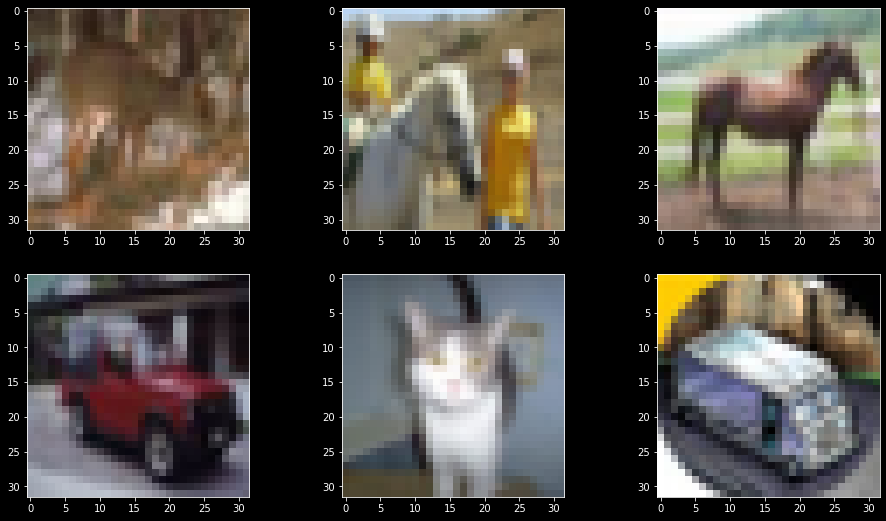

In [6]:
fig, axes = plt.subplots(2, 3, figsize=(16, 9))
axes = axes.reshape(-1)
for ax in axes:
    ax.imshow(x_train[np.random.randint(len(x_train)), ...])
plt.show()

### Preprocessing

In [7]:
# Rescale the images from [0,255] to the [0.0,1.0] range.
def normalize(x):
    return (x-np.mean(x, axis=0))/np.std(x, axis=0)
x_train, x_test = normalize(x_train), normalize(x_test)

### Data pipeline

In [8]:
batch_size = 128
buffer_size = batch_size * 1024
dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train)).batch(batch_size)
for x, y in dataset.take(1):
    print(x.shape, y.shape)

(128, 32, 32, 3) (128, 1)


### Model

In [9]:
# Parameters for model architecture
units = 1000
rank = 32
n_classes = 10
activation = 'relu'
N = 7

In [10]:
def residual_block(inputs, filters=64, kernel_size=(1, 1)):
    input_channel = inputs.shape[-1]
    output_channel = filters
    if input_channel * 2 == output_channel:
        increase_dim = True
        strides = (2, 2)
    elif input_channel == output_channel:
        increase_dim = False
        strides = (1, 1)
    else:
        raise ValueError('Output and input channel does not match in residual blocks!!!')
    # Batch norm
    outputs = tf.keras.layers.BatchNormalization()(inputs)
    # Pre-activation 
    outputs = tf.keras.activations.get(activation)(outputs)
    # Convolution
    outputs = tf.keras.layers.Conv2D(filters, kernel_size=kernel_size, activation=None, strides=strides, padding='same')(outputs)
    # Batch norm
    outputs = tf.keras.layers.BatchNormalization()(outputs)
    # Pre-activation 
    outputs = tf.keras.activations.get(activation)(outputs)
    # Convolution
    outputs = tf.keras.layers.Conv2D(filters, kernel_size=kernel_size, activation=None, padding='same')(outputs)
    if increase_dim:
        inputs = tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid')(inputs)
        inputs = tf.pad(inputs, [[0, 0], [0, 0], [0, 0], [input_channel // 2, input_channel // 2]])

    return tf.keras.layers.Add()([inputs, outputs])

In [11]:
def build_model(units, rank, n=N):
    # Make input layer
    inputs = tf.keras.Input(shape=x.shape[1:])
    # Convolutional layer
    hidden = tf.keras.layers.Conv2D(32, kernel_size=(3, 3), activation=None, padding='same')(inputs)
    # Residual block
    for i in range(n):
        hidden = residual_block(hidden, 32, (3, 3))
    for i in range(n):
        # Residual block
        hidden = residual_block(hidden, 64, (3, 3))
    for i in range(n):
        # Residual block
        hidden = residual_block(hidden, 128, (3, 3))
    hidden = tf.keras.layers.GlobalAveragePooling2D()(hidden)
    # Flatten
    hidden = tf.keras.layers.Flatten()(hidden)
    # Fully connected
    if rank is None:
        hidden = tf.keras.layers.Dense(units, activation=activation)(hidden)
    else:
        hidden = SVDDense(units, rank, activation=activation)(hidden)
    # Projection layer
    outputs = tf.keras.layers.Dense(n_classes, 'softmax')(hidden)
    # Make & compile model
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model

In [12]:
gpus = tf.config.list_physical_devices('GPU')
print(gpus)
if gpus:
    # Restrict TensorFlow to only use the first GPU
    try:
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
    except RuntimeError as e:
        # Visible devices must be set before GPUs have been initialized
        print(e)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
1 Physical GPUs, 1 Logical GPU


In [13]:
# Create a MirroredStrategy for multiple gpus if wanted.
strategy = tf.distribute.MirroredStrategy()
print('Number of devices: {}'.format(strategy.num_replicas_in_sync))

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
Number of devices: 1


In [14]:
# Open a strategy scope if wanted.
# Number of epochs
epochs = 50
# Learning rates
learning_rate = 10e-3
nu = 10e-4
# acceleration parameters
beta = 0.9
gamma = 0.999
# weight_decay
alpha_conv = 0.001
alpha_dense = 0.01
alpha_bias = 0.01

# Loss and accuracy
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy()
accuracy_fn = tf.keras.metrics.SparseCategoricalAccuracy()

# learning rate schedule
schedule = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=2)

# Early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_sparse_categorical_accuracy', mode='max', verbose=1, patience=5)
decomposition_tracker = DecompositionTracker(on_batch=True)

In [15]:
def regularize(model):
    for layer in model.layers:
        if isinstance(layer, tf.keras.layers.Conv2D):
            layer.add_loss(lambda: tf.keras.regularizers.l2(alpha_conv)(layer.kernel))
        elif isinstance(layer, tf.keras.layers.Dense):
            layer.add_loss(lambda: tf.keras.regularizers.l2(alpha_dense)(layer.kernel))
        elif isinstance(layer, SVDDense):
            layer.add_loss(lambda: tf.keras.regularizers.l2(alpha_dense)(layer.trainable_variables[1]))
        if hasattr(layer, 'bias_regularizer') and layer.use_bias:
            layer.add_loss(lambda: tf.keras.regularizers.l2(alpha_bias)(layer.bias))
    return model

In [17]:
# Open a strategy scope if wanted.
regular_model = build_model(units, None)
regular_model = regularize(regular_model)
# SVD optimizer
optimizer = SVDAdam(regular_model, 10e-3, nu, beta, gamma, method='chi', k=None)
# Compile model
regular_model.compile(optimizer, loss_fn, metrics=[accuracy_fn])
# Early stopping
callbacks = [early_stopping , decomposition_tracker]
# Train model
regular_history = regular_model.fit(dataset, epochs=20, validation_data=(x_test, y_test), callbacks=callbacks, verbose=1)

Epoch 1/20
391/391 [==============================] - 66s 115ms/step - loss: 5.9626 - sparse_categorical_accuracy: 0.1924 - val_loss: 2.2166 - val_sparse_categorical_accuracy: 0.2890
Epoch 2/20
391/391 [==============================] - 44s 112ms/step - loss: 2.0039 - sparse_categorical_accuracy: 0.2729 - val_loss: 1.9241 - val_sparse_categorical_accuracy: 0.2716
Epoch 3/20
391/391 [==============================] - 45s 114ms/step - loss: 1.7671 - sparse_categorical_accuracy: 0.3139 - val_loss: 1.7353 - val_sparse_categorical_accuracy: 0.3483
Epoch 4/20
391/391 [==============================] - 43s 110ms/step - loss: 1.5914 - sparse_categorical_accuracy: 0.3971 - val_loss: 1.6640 - val_sparse_categorical_accuracy: 0.3812
Epoch 5/20
391/391 [==============================] - 44s 112ms/step - loss: 1.5143 - sparse_categorical_accuracy: 0.4417 - val_loss: 1.6686 - val_sparse_categorical_accuracy: 0.4353
Epoch 6/20
391/391 [==============================] - 43s 109ms/step - loss: 1.3935 -

In [18]:
# SVD optimizer
optimizer = SVDAdam(regular_model, 10e-4, nu, beta, gamma, method='chi', k=None)
# Compile model
regular_model.compile(optimizer, loss_fn, metrics=[accuracy_fn])
# Early stopping
callbacks = [early_stopping , decomposition_tracker]
# Train model
regular_history_ = regular_model.fit(dataset, epochs=10, validation_data=(x_test, y_test), callbacks=callbacks, verbose=1)

Epoch 1/10
391/391 [==============================] - 65s 111ms/step - loss: 0.3553 - sparse_categorical_accuracy: 0.8617 - val_loss: 0.5505 - val_sparse_categorical_accuracy: 0.8287
Epoch 2/10
391/391 [==============================] - 41s 106ms/step - loss: 0.2979 - sparse_categorical_accuracy: 0.9074 - val_loss: 0.5632 - val_sparse_categorical_accuracy: 0.8306
Epoch 3/10
391/391 [==============================] - 43s 109ms/step - loss: 0.2578 - sparse_categorical_accuracy: 0.9214 - val_loss: 0.6013 - val_sparse_categorical_accuracy: 0.8271
Epoch 4/10
391/391 [==============================] - 41s 106ms/step - loss: 0.2201 - sparse_categorical_accuracy: 0.9353 - val_loss: 0.6637 - val_sparse_categorical_accuracy: 0.8261
Epoch 5/10
391/391 [==============================] - 42s 107ms/step - loss: 0.1841 - sparse_categorical_accuracy: 0.9493 - val_loss: 0.7487 - val_sparse_categorical_accuracy: 0.8202
Epoch 6/10
391/391 [==============================] - 41s 106ms/step - loss: 0.1520 -

In [19]:
# SVD optimizer
optimizer = SVDAdam(regular_model, 10e-5, nu, beta, gamma, method='chi', k=None)
# Compile model
regular_model.compile(optimizer, loss_fn, metrics=[accuracy_fn])
# Early stopping
callbacks = [early_stopping , decomposition_tracker]
# Train model
regular_history__ = regular_model.fit(dataset, epochs=10, validation_data=(x_test, y_test), callbacks=callbacks, verbose=1)

Epoch 1/10
391/391 [==============================] - 66s 114ms/step - loss: 0.1160 - sparse_categorical_accuracy: 0.9437 - val_loss: 0.7751 - val_sparse_categorical_accuracy: 0.8363
Epoch 2/10
391/391 [==============================] - 43s 110ms/step - loss: 0.0960 - sparse_categorical_accuracy: 0.9769 - val_loss: 0.7847 - val_sparse_categorical_accuracy: 0.8352
Epoch 3/10
391/391 [==============================] - 43s 110ms/step - loss: 0.0877 - sparse_categorical_accuracy: 0.9801 - val_loss: 0.8019 - val_sparse_categorical_accuracy: 0.8353
Epoch 4/10
391/391 [==============================] - 43s 109ms/step - loss: 0.0816 - sparse_categorical_accuracy: 0.9822 - val_loss: 0.8203 - val_sparse_categorical_accuracy: 0.8340
Epoch 5/10
391/391 [==============================] - 43s 109ms/step - loss: 0.0766 - sparse_categorical_accuracy: 0.9837 - val_loss: 0.8392 - val_sparse_categorical_accuracy: 0.8335
Epoch 6/10
391/391 [==============================] - 43s 109ms/step - loss: 0.0721 -

### Rank dependence

In [20]:
# empty dicts for models & histories
models_rank = {}
histories_rank = {}
trackers_rank = {}

In [21]:
ranks = [64, 32]
for rank in ranks:
    # Make trackers
    orthogonality_tracker = OrthogonalityTracker(on_batch=True)
    conditioning_tracker = ConditioningTracker(on_batch=True)
    # Make model
    model = build_model(units, rank)
    model = regularize(model)
    # SVD optimizer
    optimizer = SVDAdam(model, 10e-3, nu, beta, gamma)
    # Compile model
    model.compile(optimizer, loss_fn, metrics=[accuracy_fn])
    # Callbacks
    callbacks = [early_stopping]
    # Add trackers to callbacks
    callbacks += [orthogonality_tracker, conditioning_tracker]
    # History
    history = model.fit(dataset, epochs=20, validation_data=(x_test, y_test), callbacks=callbacks, verbose=1)
    # SVD optimizer
    optimizer = SVDAdam(model, 10e-4, nu, beta, gamma)
    # 
    trackers_rank[rank] = callbacks
    # Compile model
    model.compile(optimizer, loss_fn, metrics=[accuracy_fn])
    # History
    history_ = model.fit(dataset, epochs=10, validation_data=(x_test, y_test), callbacks=callbacks, verbose=1)
    # SVD optimizer
    optimizer = SVDAdam(model, 10e-5, nu, beta, gamma)
    # Compile model
    model.compile(optimizer, loss_fn, metrics=[accuracy_fn])
    # History
    history__ = model.fit(dataset, epochs=10, validation_data=(x_test, y_test), callbacks=callbacks, verbose=1)
    # Train model
    histories_rank[rank] = {key: tf.concat([history.history[key], history_.history[key], history__.history[key]], axis=0) for key in history.history.keys()}
    models_rank[rank] = model


Epoch 1/20
391/391 [==============================] - 62s 103ms/step - loss: 5.2226 - sparse_categorical_accuracy: 0.3562 - val_loss: 2.2110 - val_sparse_categorical_accuracy: 0.2893
Epoch 2/20
391/391 [==============================] - 39s 100ms/step - loss: 1.8330 - sparse_categorical_accuracy: 0.3561 - val_loss: 1.7474 - val_sparse_categorical_accuracy: 0.3779
Epoch 3/20
391/391 [==============================] - 39s 100ms/step - loss: 1.6078 - sparse_categorical_accuracy: 0.4245 - val_loss: 1.4750 - val_sparse_categorical_accuracy: 0.4747
Epoch 4/20
391/391 [==============================] - 39s 101ms/step - loss: 1.4163 - sparse_categorical_accuracy: 0.4995 - val_loss: 1.3446 - val_sparse_categorical_accuracy: 0.5153
Epoch 5/20
391/391 [==============================] - 39s 100ms/step - loss: 1.2736 - sparse_categorical_accuracy: 0.5549 - val_loss: 1.3392 - val_sparse_categorical_accuracy: 0.5415
Epoch 6/20
391/391 [==============================] - 39s 100ms/step - loss: 1.1495 -

In [22]:
plt.style.use('grayscale')
params = {'legend.fontsize': '22',
          'figure.figsize': (16, 9),
         'axes.labelsize': '22',
         'axes.titlesize':'22',
         'xtick.labelsize':'18',
         'ytick.labelsize':'18'}
plt.rcParams.update(params)

In [23]:
histories_rank_backup = histories_rank
# histories_rank.pop(128)
hist = {key: tf.concat([
    regular_history.history[key], 
    regular_history_.history[key], 
    regular_history__.history[key]], axis=0) for key in regular_history.history.keys()}

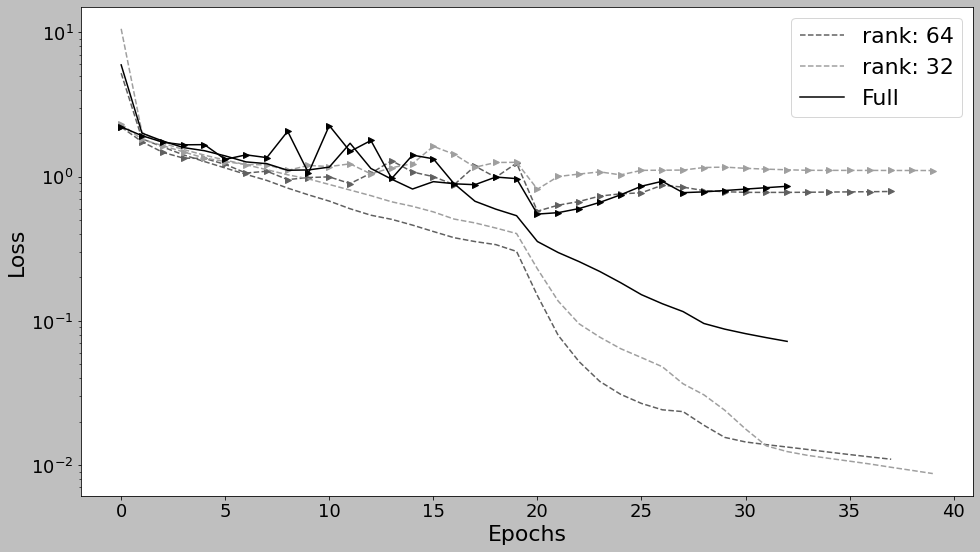

In [24]:
plt.figure(figsize=(16, 9))
for rank, history in histories_rank.items():
    if not isinstance(history, dict):
        history = history.history
    plt.plot(history['loss'], label=f'rank: {rank}', linestyle='dashed', color=str((7.5 - np.log2(rank))/4))
    plt.plot(history['val_loss'], linestyle='dashed', marker='>', color=str((7.5 - np.log2(rank))/4))
plt.plot(hist['loss'], label=f'Full', color='black')
plt.plot(hist['val_loss'], marker='>', color='black')
plt.yscale('log')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend()
plt.savefig('figures/CIFAR10_loss.png')
plt.show()

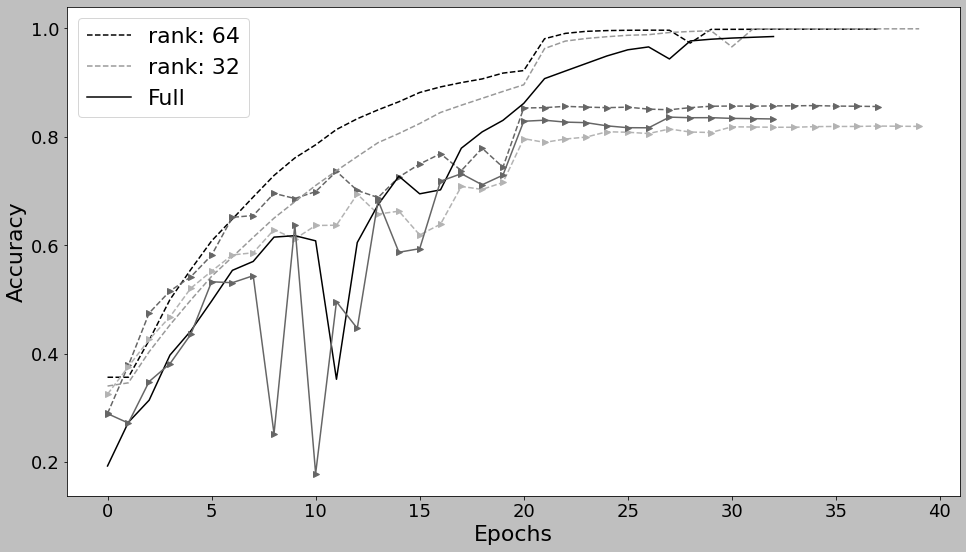

In [25]:
plt.figure(figsize=(16, 9))
for rank, history in histories_rank.items():
    plt.plot(history['sparse_categorical_accuracy'], label=f'rank: {rank}', linestyle='dashed')
    plt.plot(history['val_sparse_categorical_accuracy'], marker='>', linestyle='dashed')
plt.plot(hist['sparse_categorical_accuracy'], label=f'Full')
plt.plot(hist['val_sparse_categorical_accuracy'], marker='>')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend()
plt.savefig('figures/CIFAR10_accuracy.png')
plt.show()

In [26]:
N = 250

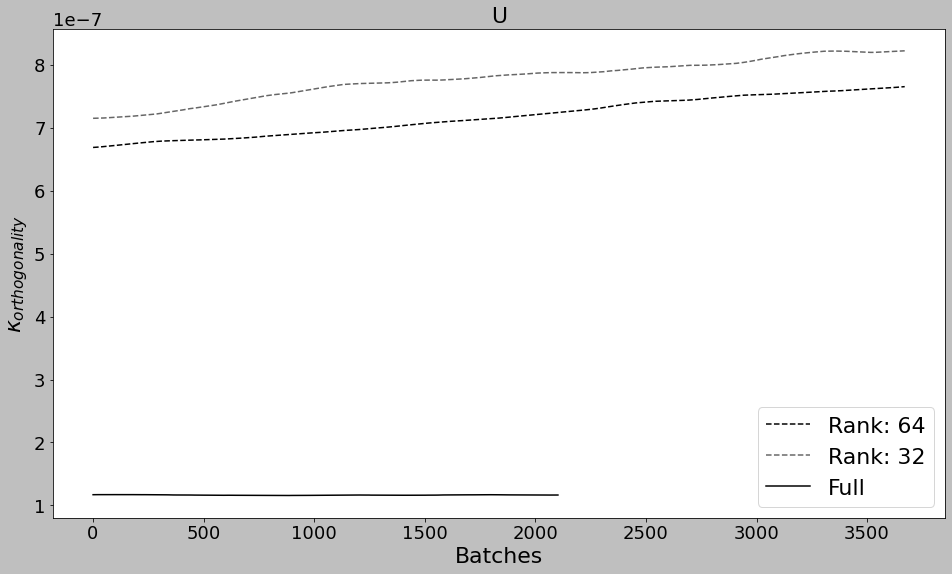

In [27]:
plt.figure(figsize=(16, 9))
for rank, track in trackers_rank.items():
    ortho = track[1].kappa
    values = ortho[list(ortho.keys())[0]]['u']
    plt.plot(np.convolve(values, np.ones(N), mode='valid'), label=f'Rank: {rank}', linestyle='dashed')
for layer, values in decomposition_tracker.kappa.items():
    plt.plot(np.convolve(values['u'], np.ones(N), mode='valid'), label=f'Full', color='black')
    break

plt.title('U')
plt.xlabel('Batches')
plt.ylabel('$\kappa_{orthogonality}$')
plt.legend()
plt.savefig('figures/CIFAR10_orthogonality_u.png')
plt.show()

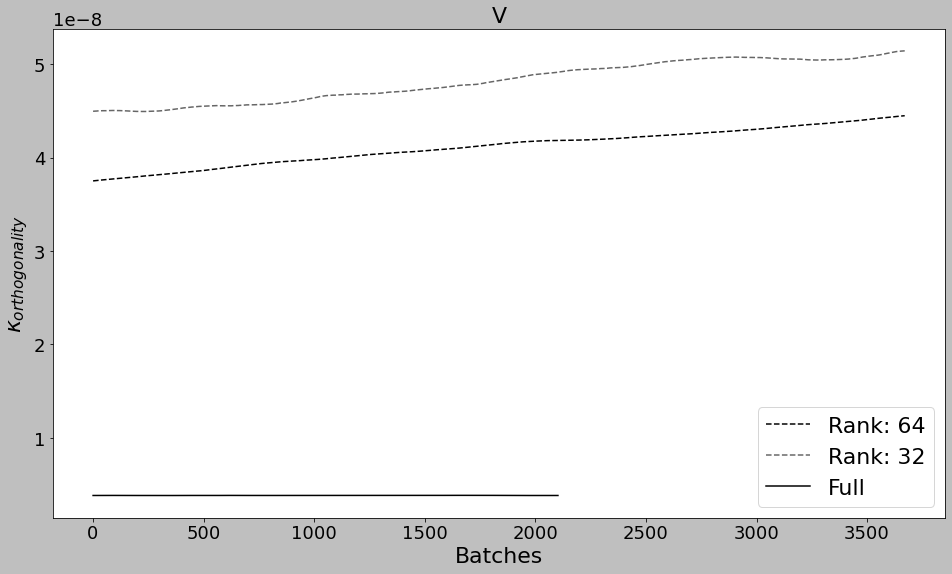

In [28]:
plt.figure(figsize=(16, 9))
for rank, track in trackers_rank.items():
    ortho = track[1].kappa
    values = ortho[list(ortho.keys())[0]]['v']
    plt.plot(np.convolve(values, np.ones(N), mode='valid'), label=f'Rank: {rank}', linestyle='dashed')
for layer, values in decomposition_tracker.kappa.items():
    plt.plot(np.convolve(values['v'], np.ones(N), mode='valid'), label=f'Full', color='black')
    break
    
plt.title('V')
plt.xlabel('Batches')
plt.ylabel('$\kappa_{orthogonality}$')
plt.legend()
plt.savefig('figures/CIFAR10_orthogonality_v.png')
plt.show()

In [29]:
for rank, model in models_rank.items():
    print(rank)
    print(np.sum([var.numpy().size for var in model.trainable_variables]))
print(np.sum([var.numpy().size for var in regular_model.trainable_variables]))

64
2710722
32
2674594
2766466


In [ ]:
for rank, model in models_rank.items():
    print(np.mean([accuracy_fn(y, model(x)) for x, y in dataset]))
print(np.mean([accuracy_fn(y, model(x)) for x, y in dataset]))

In [ ]:
for model in models_rank.values():
    print(np.mean([accuracy_fn(y, model(x)) for x, y in [(x_test, y_test)]]))
print(np.mean([accuracy_fn(y, model(x)) for x, y in [(x_test, y_test)]]))

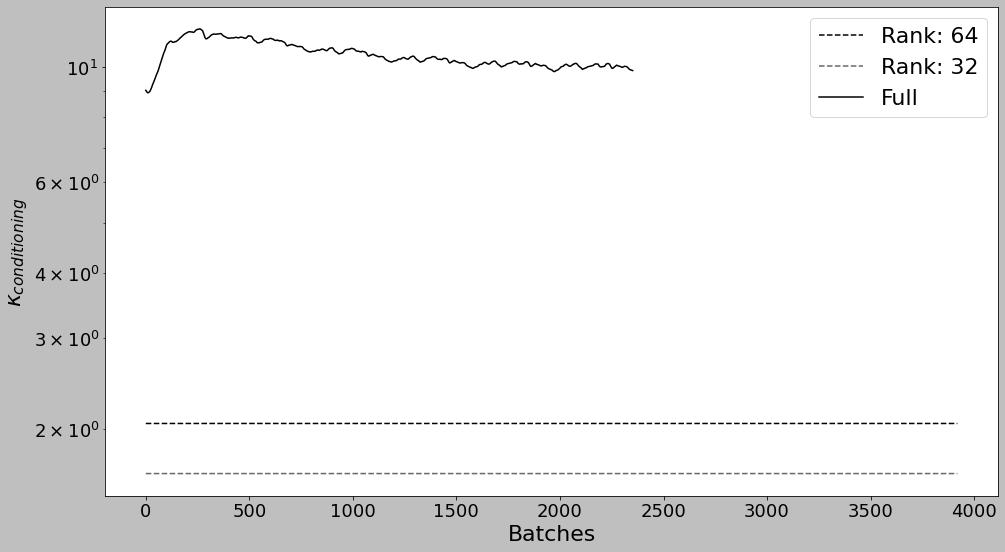

In [33]:
plt.figure(figsize=(16, 9))
for rank, track in trackers_rank.items():
    cond = track[2].kappa
    plt.plot(cond[list(cond.keys())[0]], label=f'Rank: {rank}', linestyle='dashed')
for layer, values in list(decomposition_tracker.kappa.items())[-1:]:
    plt.plot(values['s'], label='Full', color='black')
plt.yscale('log')
plt.xlabel('Batches')
plt.ylabel('$\kappa_{conditioning}$')
plt.legend()
plt.savefig('figures/CIFAR10_conditioning.png')
plt.show()

In [ ]:
for model in list(models_rank.values()):
    print(np.mean(y_test == np.argmax(model(x_test), axis=-1)))

In [ ]:
print(np.mean(y_test == np.argmax(regular_model(x_test), axis=-1)))

### Adversial attack

In [141]:
def create_adversarial_pattern(model, input_image, input_label):
    with tf.GradientTape() as tape:
        tape.watch(input_image)
        prediction = model(input_image)
        loss = loss_fn(input_label, prediction)

    # Get the gradients of the loss w.r.t to the input image.
    gradient = tape.gradient(loss, input_image)
    # Get the sign of the gradients to create the perturbation
    signed_grad = tf.sign(gradient)
    return signed_grad

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


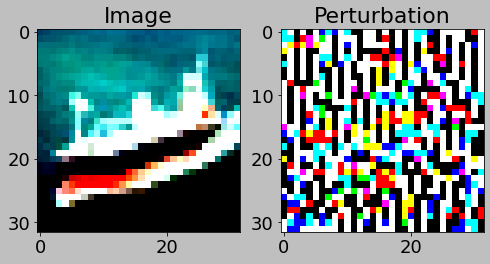

In [142]:
index = np.random.randint(len(x_train))
image = x_train[index, ...]
label = y_train[index]

perturbations = create_adversarial_pattern(regular_model, tf.convert_to_tensor(image[np.newaxis, ...]), [label])

fig, axes = plt.subplots(1, 2, figsize=(8, 4))
axes[0].imshow(image)
axes[1].imshow(perturbations[0] * 0.5 + 0.5);  # To change [-1, 1] to [0,1]
axes[0].set_title('Image')
axes[1].set_title('Perturbation')
plt.show()

In [143]:
def run_adversial(model, verbose=True):
    epsilons = [0, 0.01, 0.1, 0.15, 0.2]
    descriptions = [('Epsilon = {:0.3f}'.format(eps) if eps else 'Input')
                    for eps in epsilons]

    for i, eps in enumerate(epsilons):
        adv_x = image + eps * perturbations
        adv_x = tf.clip_by_value(adv_x, -1, 1)
        probabilities = model(adv_x)
        prediction = np.argmax(probabilities)
        
        if verbose:
            print(f'Predicted class: {prediction} with probability {probabilities[..., prediction]}')
    return probabilities

In [144]:
print('Adversial on regular model')
model = regular_model
probabilities = run_adversial(model)

for rank in [32, 64, 128]:
    print(f'Adversial on SVD model with rank {rank}')
    model = models_rank[rank]
    probabilities = run_adversial(model)

Adversial on regular model
Predicted class: 8 with probability [1.]
Predicted class: 8 with probability [1.]
Predicted class: 8 with probability [1.]
Predicted class: 8 with probability [1.]
Predicted class: 8 with probability [1.]
Adversial on SVD model with rank 32
Predicted class: 8 with probability [1.]
Predicted class: 8 with probability [1.]
Predicted class: 8 with probability [1.]
Predicted class: 8 with probability [1.]
Predicted class: 8 with probability [1.]
Adversial on SVD model with rank 64
Predicted class: 8 with probability [1.]
Predicted class: 8 with probability [1.]
Predicted class: 8 with probability [1.]
Predicted class: 8 with probability [1.]
Predicted class: 8 with probability [1.]
Adversial on SVD model with rank 128
Predicted class: 8 with probability [1.]
Predicted class: 8 with probability [1.]
Predicted class: 8 with probability [1.]
Predicted class: 8 with probability [1.]
Predicted class: 8 with probability [1.]


In [145]:
def adversial(model, examples, eps=0.0):
    ces = []
    acc = []

    for image, label in examples:
        perturbations = create_adversarial_pattern(model, tf.convert_to_tensor(image[np.newaxis, ...]), [label])
        adv_x = image + eps * perturbations
        adv_x = tf.clip_by_value(adv_x, -1, 1)
        probabilities = model(adv_x)
        cross_entropy = tf.keras.losses.sparse_categorical_crossentropy([label], probabilities)
        f1 = tf.keras.metrics.sparse_categorical_accuracy([label], probabilities)
        acc.append(f1)
        ces.append(cross_entropy)
    return (np.mean(ces), np.mean(acc))

In [146]:
n_adversial = 250
indices = np.random.choice(range(len(x_train)), n_adversial)

In [147]:
results = {}
for eps in [0.0, 0.01, 0.05, 0.1]:
    reg = {
        'Full': adversial(regular_model, zip(x_train[indices, ...], y_train[indices, ...]), eps), 
    }
    svd = {
        f'Rank: {rank}': adversial(models_rank[rank], zip(x_train[indices, ...], y_train[indices, ...]), eps)
        for rank in [32, 64, 128]
    }
    results[eps] = {**reg, **svd}

In [148]:
ce_adversial = pd.DataFrame(results)
ce_adversial

,0.00,0.01,0.05,0.10
Full,"(0.46908775, 0.916)","(1.022293, 0.796)","(4.119222, 0.444)","(5.787717, 0.3)"
Rank: 32,"(0.5020637, 0.88)","(1.3615786, 0.728)","(4.888347, 0.356)","(6.7599797, 0.264)"
Rank: 64,"(0.58895445, 0.864)","(1.784227, 0.672)","(6.486963, 0.336)","(7.569948, 0.264)"
Rank: 128,"(0.2859569, 0.936)","(0.7659249, 0.844)","(4.007004, 0.492)","(6.204, 0.34)"


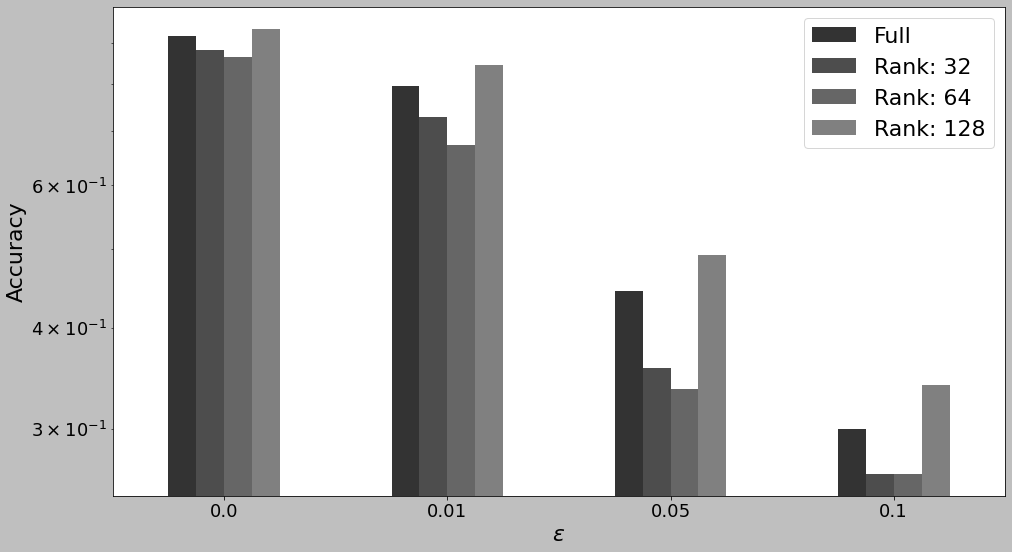

In [154]:
fig, axes = plt.subplots(1, 1, figsize=(16, 9))
plt.style.use('grayscale')
values = ce_adversial.T.applymap(lambda s: s[1])
axes = values.plot.bar(ax=axes, color={row: (0.2 + i * 0.1, 0.2 + i * 0.1, 0.2 + i * 0.1) for i, row in enumerate(ce_adversial.index)})
plt.xticks(rotation=0)
plt.yscale('log')
plt.ylabel('Accuracy')
plt.xlabel('$\epsilon$')
plt.savefig('adversial_Accuracies_CIFAR10.png')
plt.show()
